# Visualize detection results

This notebook visualize the detection results of different models on the same set of images. The visualizations are used in the thesis report

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
import torch.nn.functional as nnF
import torchvision.transforms.functional as F
import torchvision.transforms as pth_transforms

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches

import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style("white", {
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': ['Arial',
        'Droid Sans',
        'sans-serif'
    ],
})

%matplotlib inline
# import seaborn as sns
# sns.set()

from sparse_detector.configs import (
    build_dataset_config,
    build_detr_config,
    load_config
)
from sparse_detector.models import build_model
import sparse_detector.datasets.transforms as T
from sparse_detector.visualizations import ColorPalette
from sparse_detector.datasets.coco import CLASSES, NORMALIZATION
from sparse_detector.utils.box_ops import rescale_bboxes

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda")

**Load model**

In [2]:
def load_model(config_file_name, model_checkpoint_dir):
    detr_config_file = Path(package_root) / "configs" / config_file_name
    base_config = load_config(Path(package_root) / "configs" / "base.yml")
    detr_config = build_detr_config(detr_config_file, params=None, device=device)

    # Surgery for path
    dataset_config = build_dataset_config(base_config["dataset"], params=None)
    dataset_config['coco_path'] = Path(package_root) / "data" / "COCO"

    detr_config["average_cross_attn_weights"] = True

    # Build model
    model, _, _ = build_model(**detr_config)
    resume_from_checkpoint = Path(package_root) / "checkpoints" / model_checkpoint_dir / "checkpoint.pth"
    checkpoint = torch.load(resume_from_checkpoint, map_location="cpu")
    model.load_state_dict(checkpoint["model"])
    model.eval()
    model.to(device)
    return model, detr_config, dataset_config

In [3]:
softmax_model, softmax_config, dataset_config = load_model("detr_baseline.yml", "v2_baseline_detr")
sparsemax_model, _, _ = load_model("decoder_sparsemax_baseline.yml", "v2_decoder_sparsemax")
entmax_model, _, dataset_config = load_model("decoder_entmax15_baseline.yml", "v2_decoder_entmax15")
alpha_entmax_model, _, _ = load_model("decoder_alpha_entmax.yml", "v2_decoder_alpha_entmax")

Cross-attention activation: softmax; average attention weights: True
Transformer.reset_parameters()
Cross-attention activation: sparsemax; average attention weights: True
Transformer.reset_parameters()
Cross-attention activation: entmax15; average attention weights: True
Transformer.reset_parameters()
Cross-attention activation: alpha_entmax; average attention weights: True
Transformer.reset_parameters()


**Load images**

In [4]:
coco_path = dataset_config['coco_path']
test_img_ids = [350405, 29596, 577149]

def load_image(img_id):
    img_path = coco_path / "val2017" / (f"{img_id}".rjust(12, '0') + '.jpg')
    pil_img = Image.open(img_path)

    resize_transform = T.RandomResize([800], max_size=1333)
    resize_image, _ = resize_transform(pil_img)

    transforms = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize(NORMALIZATION["mean"], NORMALIZATION["std"]),
    ])

    input_tensor = transforms(resize_image).unsqueeze(0).to(device)
    return input_tensor, pil_img

In [5]:
def predict_image(model, input_tensor, threshold=0.9, img_size=None):
    outputs = model(input_tensor)
    pred_logits = outputs['pred_logits'].detach().cpu()
    pred_boxes = outputs['pred_boxes'].detach().cpu()

    probas = pred_logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    bboxes_scaled = rescale_bboxes(pred_boxes[0, keep], img_size)
    return probas, keep, bboxes_scaled

In [6]:
def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(8,6))
    plt.imshow(pil_img)
    ax = plt.gca()
    ax.axis('off')
    for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=ColorPalette.RED, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.4f}'
        ax.text(xmin, ymin-15, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

**Get detection for an example image**

In [7]:
def visualize_for_model(model, out_file_name = None):
    results = dict()
    for img_id in test_img_ids:
        print(f"Loading image {img_id}")
        input_tensor, pil_img = load_image(img_id)

        print(f"Making prediction for {img_id}")
        probas, keep, bboxes_scaled = predict_image(
            model, input_tensor, threshold=0.9, img_size=pil_img.size
        )
        results[str(img_id)] = {
            "pil_img": pil_img,
            "probas": probas,
            "keep": keep,
            "bboxes_scaled": bboxes_scaled
        }
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(30, 10))

    for idx, (img_id, data) in enumerate(results.items()):
        ax = axs[idx]
        ax.imshow(data["pil_img"])
        ax.axis('off')
        probas = data["probas"]
        keep = data["keep"]
        prob = probas[keep]
        boxes = data["bboxes_scaled"]
        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=ColorPalette.RED, linewidth=3))
            cl = p.argmax()
            text = f'{CLASSES[cl]}: {p[cl]:0.4f}'
            ax.text(xmin, ymin-15, text, fontsize=15,
                    bbox=dict(facecolor='yellow', alpha=0.5))
    
        ax.set_aspect('equal')
    
    fig.subplots_adjust(wspace=0.02)

    # if out_file_name:
    #     fig.savefig(f"images/{out_file_name}.png", bbox_inches="tight")
    #     fig.savefig(f"images/{out_file_name}.pdf", bbox_inches="tight")

In [8]:
visualize_for_model(softmax_model, out_file_name="softmax_detection_viz")

Loading image 350405
Making prediction for 350405
Loading image 29596
Making prediction for 29596
Loading image 577149
Making prediction for 577149


Loading image 350405
Making prediction for 350405
Loading image 29596
Making prediction for 29596
Loading image 577149
Making prediction for 577149


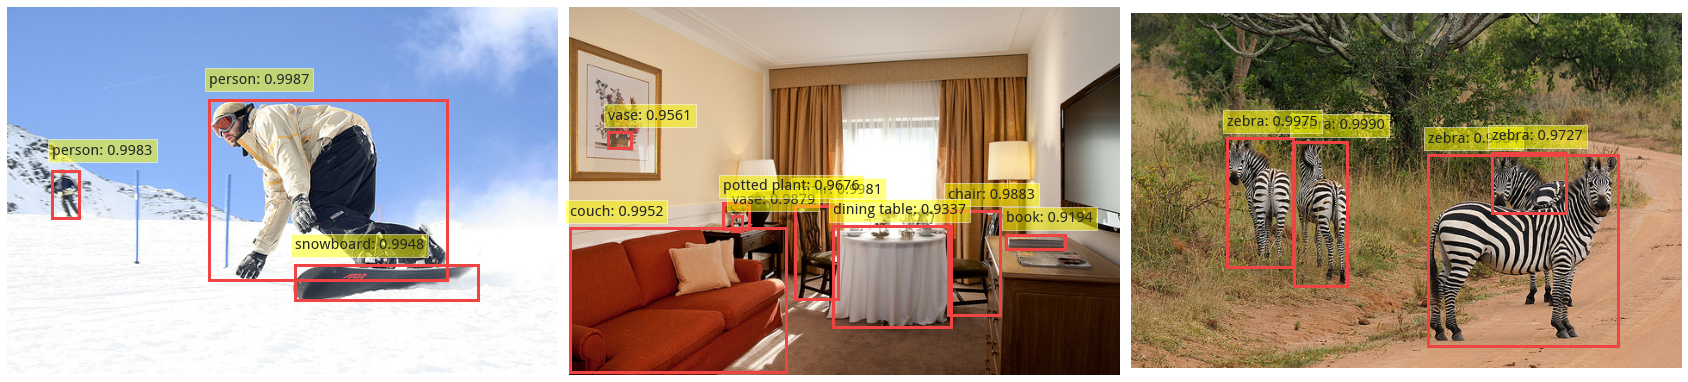

In [9]:
visualize_for_model(sparsemax_model, out_file_name="sparsemax_detection_viz")

Cross-attention activation: entmax15; average attention weights: True
Transformer.reset_parameters()
Loading image 350405
Making prediction for 350405
Loading image 29596
Making prediction for 29596
Loading image 577149
Making prediction for 577149


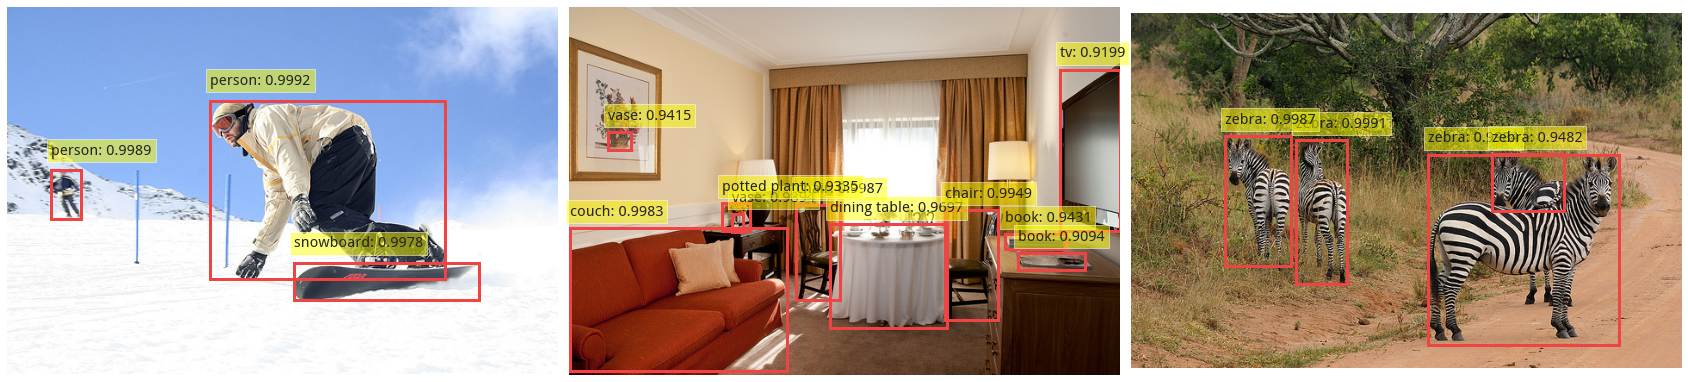

In [10]:
entmax_model, _, _ = load_model("decoder_entmax15_baseline.yml", "v2_decoder_entmax15")
visualize_for_model(entmax_model, out_file_name="entmax_detection_viz")

Cross-attention activation: alpha_entmax; average attention weights: True
Transformer.reset_parameters()
Loading image 350405
Making prediction for 350405
Loading image 29596
Making prediction for 29596
Loading image 577149
Making prediction for 577149


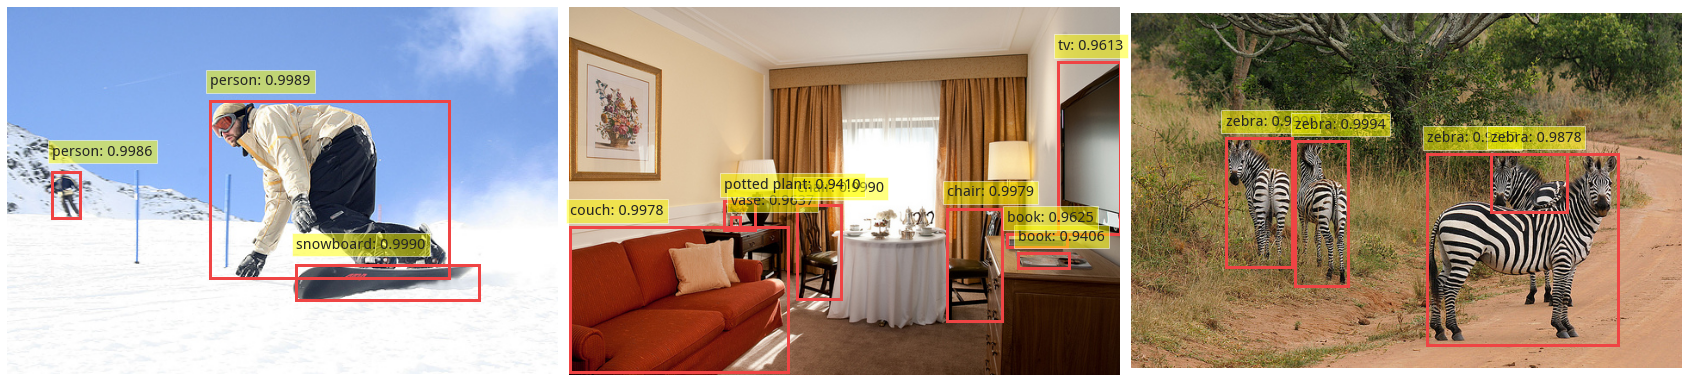

In [11]:
alpha_entmax_model, _, _ = load_model("decoder_alpha_entmax.yml", "v2_decoder_alpha_entmax")
visualize_for_model(alpha_entmax_model, out_file_name="alpha_entmax_detection_viz")

**Ground-truth visualizations**

In [7]:
# Read the dataset annotations
import json

anno_path = coco_path / "annotations" / "instances_val2017.json"
with open(anno_path, "r") as f:
    data = json.load(f)

annotations = data['annotations']
categories = data['categories']

def get_category_by_id(cat_id):
    return next(x for x in categories if x['id'] == cat_id)

In [8]:
def get_annotations_for_image(img_id):
    return list(
        filter(lambda x: x["image_id"] == img_id, annotations)
    )

In [22]:
gt_results = dict()

# test_img_ids = [242060, 250205, 239773, 320743, 574810, 8629, 13348, 18380, 38829, 54164, 568290]
test_img_ids = [350405]

for img_id in test_img_ids:
    _, pil_img = load_image(img_id)
    annos = get_annotations_for_image(img_id)
    bboxes = []
    for anno in annos:
        bboxes.append({
            "image_id": anno["image_id"],
            "bbox": anno["bbox"],
            "category": get_category_by_id(anno["category_id"])["name"]
        })
    
    gt_results[str(img_id)] = dict(pil_img=pil_img, bboxes=bboxes)

**Plot ground-truth**

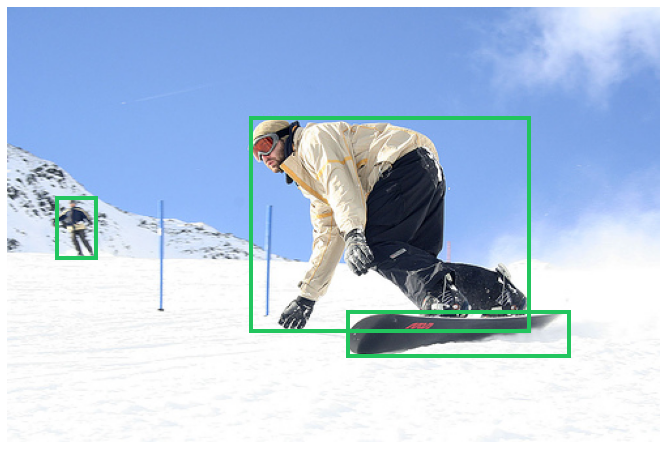

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

for idx, (img_id, data) in enumerate(gt_results.items()):
    # ax = axs[idx]
    ax.imshow(data["pil_img"])
    ax.axis('off')
    bboxes = data["bboxes"]
    for bbox in bboxes:
        (xmin, ymin, width, height) = bbox['bbox']
        ax.add_patch(plt.Rectangle((xmin, ymin), width, height,
                                fill=False, color=ColorPalette.GREEN, linewidth=4))
        # text = bbox['category']
        # ax.text(xmin, ymin, text, fontsize=12, bbox=dict(facecolor='yellow', alpha=0.5))

    ax.set_aspect('equal')

fig.subplots_adjust(wspace=0.02)

fig.savefig(f"images/presentations/{img_id}_detection_groundtruh.png", bbox_inches="tight")
# fig.savefig(f"images/detection_groundtruh.pdf", bbox_inches="tight")

In [24]:
def visualize_detections_for_an_image(img_id):
    print(f"Loading image {img_id}")
    input_tensor, pil_img = load_image(img_id)

    results_for_img = dict()

    def predict_image_with_model(input_tensor, pil_img, model):
        print(f"Making prediction for {img_id}")
        probas, keep, bboxes_scaled = predict_image(
            model, input_tensor, threshold=0.7, img_size=pil_img.size
        )
        return {
            "probas": probas,
            "keep": keep,
            "bboxes_scaled": bboxes_scaled
        }

    softmax_preds = predict_image_with_model(input_tensor, pil_img, softmax_model)
    results_for_img["softmax"] = softmax_preds
    sparsemax_preds = predict_image_with_model(input_tensor, pil_img, sparsemax_model)
    results_for_img["sparsemax"] = sparsemax_preds
    entmax_preds = predict_image_with_model(input_tensor, pil_img, entmax_model)
    results_for_img["entmax"] = entmax_preds
    alpha_entmax_preds = predict_image_with_model(input_tensor, pil_img, alpha_entmax_model)
    results_for_img["alpha_entmax"] = alpha_entmax_preds


    # fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(30, 8))

    # # First off, plot the ground-truth
    # ax = axs[0]
    # ax.imshow(pil_img)
    # ax.axis('off')

    # data = gt_results[str(img_id)]
    # bboxes = data["bboxes"]
    # for bbox in bboxes:
    #     (xmin, ymin, width, height) = bbox['bbox']
    #     ax.add_patch(plt.Rectangle((xmin, ymin), width, height,
    #                             fill=False, color=ColorPalette.GREEN, linewidth=3))

    # ax.set_aspect('equal')


    for idx, (model_name, data) in enumerate(results_for_img.items()):
        fig, ax = plt.subplots(figsize=(12, 8))
        print(model_name)
        # ax = axs[idx+1]
        ax.imshow(pil_img)
        ax.axis('off')
        probas = data["probas"]
        keep = data["keep"]
        prob = probas[keep]
        boxes = data["bboxes_scaled"]
        for p, (xmin, ymin, xmax, ymax) in zip(prob, boxes.tolist()):
            ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                    fill=False, color=ColorPalette.RED, linewidth=4))

        ax.set_aspect('equal')
            
        fig.subplots_adjust(wspace=0.02)

        fname = f"images/presentations/{img_id}_{model_name}"
        fig.savefig(fname + ".png", bbox_inches="tight")

Loading image 350405
Making prediction for 350405
Making prediction for 350405
Making prediction for 350405
Making prediction for 350405
softmax
sparsemax
entmax
alpha_entmax


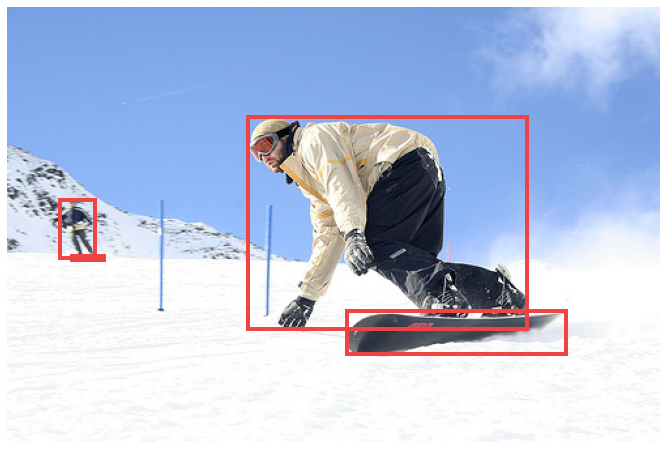

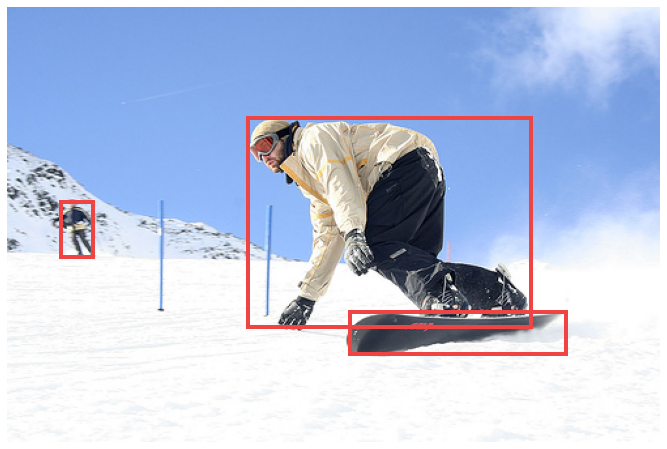

In [25]:
for img_id in test_img_ids:
    visualize_detections_for_an_image(img_id)